Loading TIFF file ...
Full image shape: (86751, 65124, 3)
Loaded ROI shape: (10256, 15256, 3)


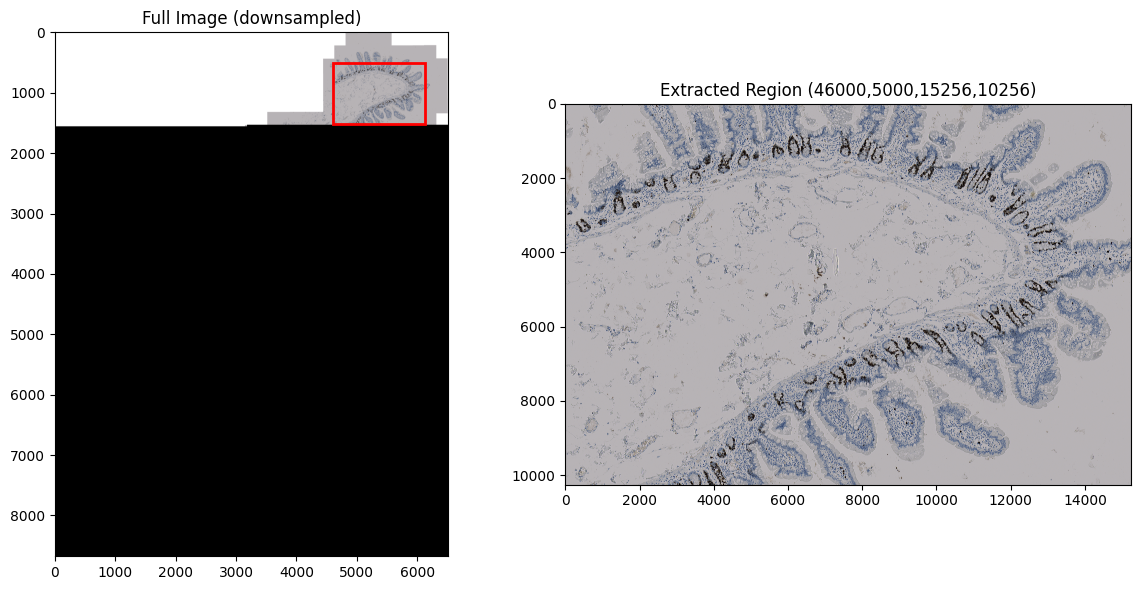

In [103]:
from tifffile import TiffFile
from tifffile import imread
import os
import matplotlib.pyplot as plt


image_path = "test.ome.tif"

# Load TIFF file from tiff_store folder
print("Loading TIFF file ...")
tiff_store_path = os.path.join('../tiff_store', image_path)

# First, check the full image dimensions
with TiffFile(tiff_store_path) as tif:
    page = tif.pages[0]
    full_data = page.asarray(out='memmap')
    print(f"Full image shape: {full_data.shape}")
    
    # Try a smaller region from a different part of the image
    # y = 10000  # Try different coordinates
    # x = 58000
    y = 5000  # Try different coordinates
    x = 46000
    width = 15256  # Smaller region for testing
    height = 10256
    
    # Extract the region of interest
    image = full_data[y:y+height, x:x+width]


print(f"Loaded ROI shape: {image.shape}")

# Display both the full image (downsampled) and the extracted region
plt.figure(figsize=(12, 6))

# Show downsampled full image
plt.subplot(1, 2, 1)
# Downsample the full image to display it (every 10th pixel)
plt.imshow(full_data[::10, ::10])
plt.title("Full Image (downsampled)")
plt.axis('on')
# Draw a rectangle to show the ROI location
plt.gca().add_patch(plt.Rectangle((x/10, y/10), width/10, height/10, 
                                 fill=False, edgecolor='red', linewidth=2))

# Show extracted region
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title(f"Extracted Region ({x},{y},{width},{height})")
plt.axis('on')

plt.tight_layout()

In [30]:
def load_image(tiff_store_path, y, x, width, height):
    with TiffFile(tiff_store_path) as tif:
        page = tif.pages[0]
        full_data = page.asarray(out='memmap')
    print(f"Full image shape: {full_data.shape}")
    
    # Extract the region of interest
    image = full_data[y:y+height, x:x+width]
    return image

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_blue_cells(image):
    # Use the image data already loaded in the previous cell
    image_uint8 = image.astype(np.uint8)

    # Create a copy for visualization
    image_rgb = image_uint8.copy()
    if len(image_uint8.shape) == 2:
        image_rgb = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2RGB)

    # Convert to HSV color space to better isolate blue
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Define range for blue color in HSV
    # Adjust these ranges based on your specific blue shade
    # lower_blue = np.array([90, 50, 50])
    lower_blue = np.array([90, 40, 40])
    upper_blue = np.array([130, 255, 255])

    # Create mask for blue regions
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Apply some morphological operations to clean up the mask
    kernel = np.ones((3,3), np.uint8)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Display results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(blue_mask, cmap='gray')
    plt.title('Blue Cell Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # Create overlay of mask on original image
    overlay = image_rgb.copy()
    overlay[blue_mask > 0] = [0, 0, 255]  # Highlight in blue
    plt.imshow(overlay)
    plt.title('Segmentation Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the segmentation mask
    cv2.imwrite('blue_cell_mask.png', blue_mask)

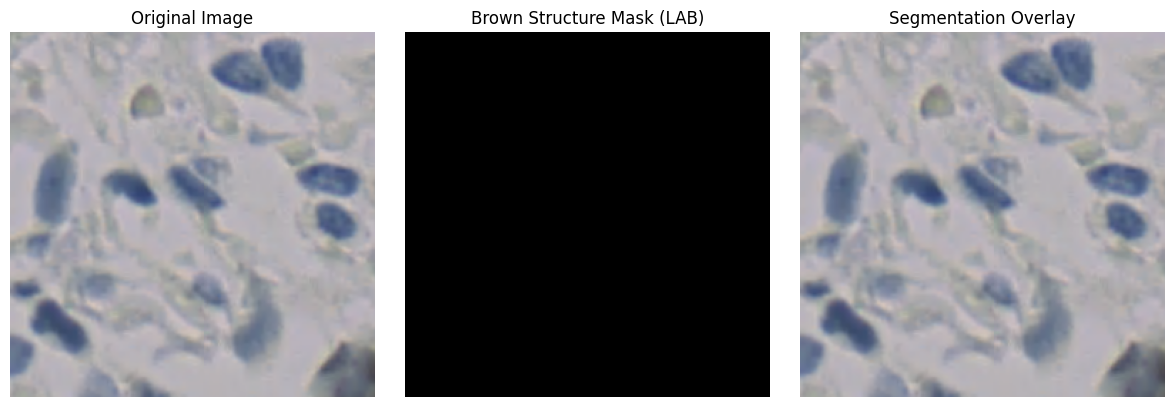

In [98]:
def segment_brown_structures_lab(image):
    # Use the image data already loaded in the previous cell
    image_uint8 = image.astype(np.uint8)

    # Create a copy for visualization
    image_rgb = image_uint8.copy()
    if len(image_uint8.shape) == 2:
        image_rgb = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2RGB)

    # Convert to LAB color space
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    
    # Split the LAB image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(lab)
    
    # For dark brown, we want low L (darkness), positive a (redness), and positive b (yellowness)
    # Threshold the L channel to get dark areas
    _, l_thresh = cv2.threshold(l_channel, 45, 255, cv2.THRESH_BINARY_INV)
    
    # Threshold the a channel to get reddish areas
    _, a_thresh = cv2.threshold(a_channel, 128, 255, cv2.THRESH_BINARY)
    
    # Combine the thresholds
    brown_mask = cv2.bitwise_and(l_thresh, a_thresh)
    
    # Apply morphological operations
    kernel = np.ones((3,3), np.uint8)
    brown_mask = cv2.morphologyEx(brown_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    brown_mask = cv2.morphologyEx(brown_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    # Display results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(brown_mask, cmap='gray')
    plt.title('Brown Structure Mask (LAB)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    overlay = image_rgb.copy()
    overlay[brown_mask > 0] = [165, 42, 42]
    plt.imshow(overlay)
    plt.title('Segmentation Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return brown_mask

# Try the LAB approach as well
brown_mask_lab = segment_brown_structures_lab(image)

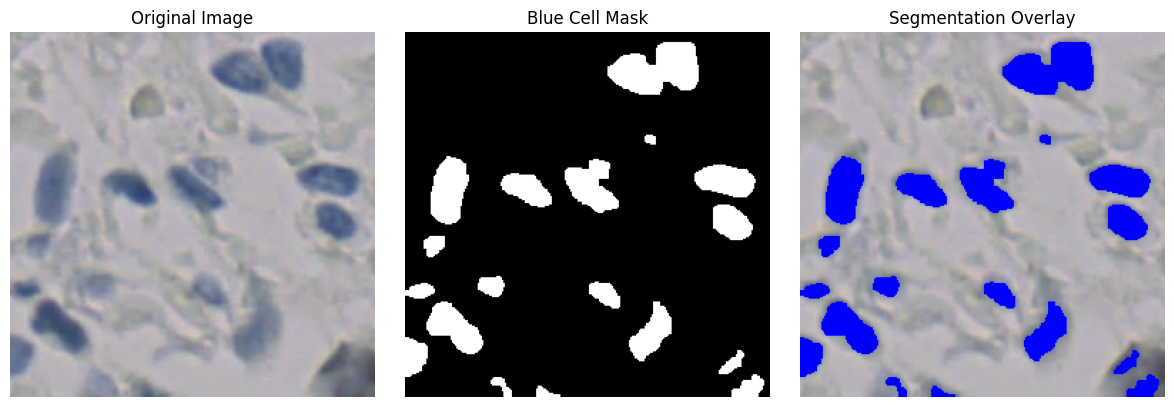

In [27]:
segment_blue_cells(image)

Full image shape: (86751, 65124, 3)


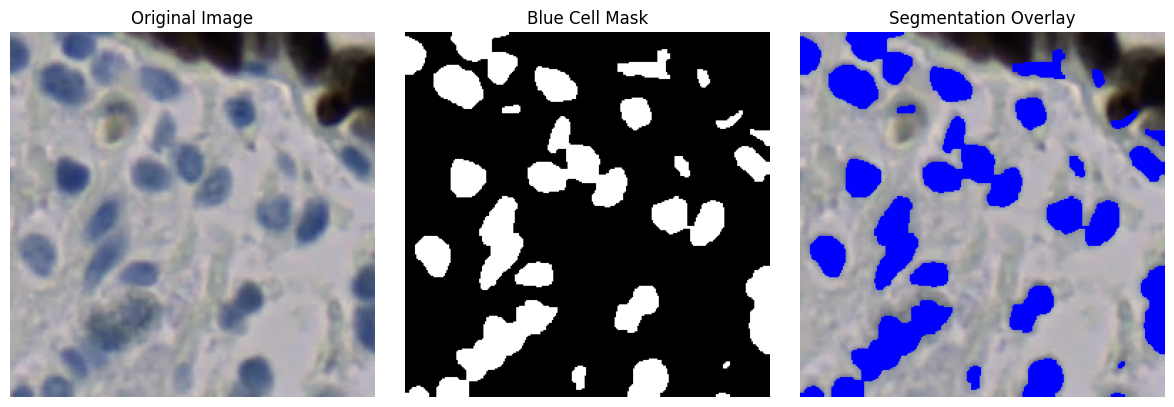

In [44]:
img = load_image("../tiff_store/test.ome.tif", 10000, 58500, 256, 256)
segment_blue_cells(img)

Full image shape: (86751, 65124, 3)


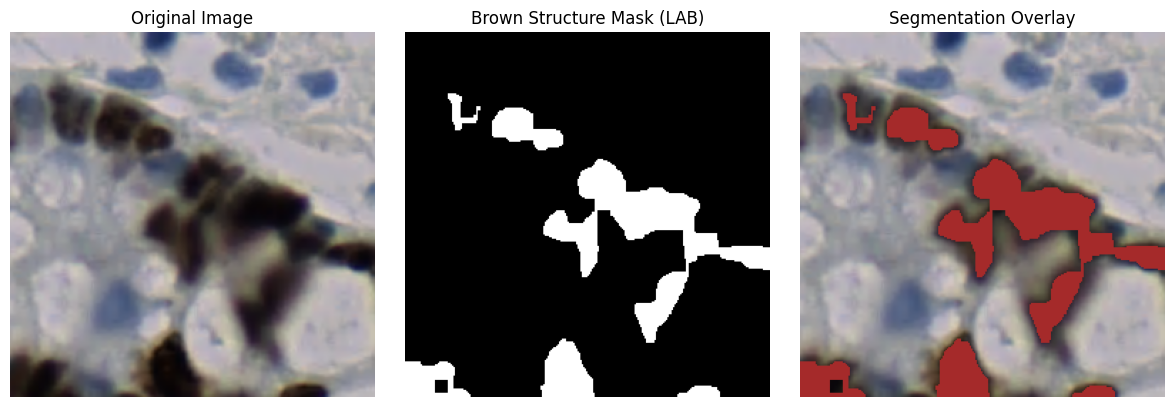

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], shape=(256, 256), dtype=uint8)

In [97]:
img = load_image("../tiff_store/test.ome.tif", 9700, 58500, 256, 256)
segment_brown_structures_lab(img)

# Split the image into patches